In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
import random
RANDOM_STATE = 17
random.seed(RANDOM_STATE)
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
#Global setpoints 
columns_input = ['line_2_inp_flow','line_2_out_flow','power'
                ]
columns_analyze = ['line_2_inp_flow','line_2_out_flow','power','target_delta_flow'
                ]

n_mean_rolling = 3 #Take only each X seconds

columns_fit = ['line_2_inp_flow','line_2_out_flow','power'] 

csv_separator = ';' #'\t'

n_prev = 5
pca_en = False
plnm = False
pca = PCA(0.99, random_state = RANDOM_STATE)
scaler = StandardScaler() #MinMaxScaler(feature_range=(-1, 1))
#scaler = MinMaxScaler(feature_range=(0, 1)) 
polynom = PolynomialFeatures(degree=2)
target_name = 'target_delta_flow'

In [31]:
#Specific preprecessor
def preprocess_data(data):  
    """
    Custom preprocessing of DataFrame
    """
    data['target_delta_flow'] = (data['line_2_out_flow'] - data['line_2_inp_flow'])
    data.dropna(inplace=True)

In [32]:
#Global function for set preparation
#X,Y data: floating window 0-30 second

def _load_data(data_X,data_y, n_prev):  
    """
    data should be pd.DataFrame()
    """
    docX, docY = [], []
    
    for i in range(len(data_X)-n_prev):
        docX.append(data_X[i:i+n_prev])
        docY.append(np.array(data_y)[i+n_prev]) #.as_matrix()
    alsX = np.array(docX)
    alsY = np.array(docY)
    #alsX = alsX.reshape((-1,n_prev,1))
    return alsX, alsY 


def _pca_scaler_data(data_X,fit_en,pca_en,plnm):  
    if len(data_X) !=0:
        if fit_en:
            X_tr_sc  = scaler.fit_transform(data_X)
            if plnm:
                X_tr_sc = polynom.fit_transform(X_tr_sc)
            if pca_en:
                X_tr_sc = pca.fit_transform(X_tr_sc)
        else:
            X_tr_sc  = scaler.transform(data_X)
            if plnm:
                X_tr_sc  = polynom.transform(X_tr_sc)
            if pca_en:
                X_tr_sc = pca.transform(X_tr_sc)   
    else:
        X_tr_sc = np.array(data_X)
        
    if len(data_X) !=0:
        X_tst_sc = scaler.transform(data_X)
        if plnm:
            X_tst_sc = polynom.transform(X_tst_sc)
        if pca_en:
            X_tst_sc = pca.transform(X_tst_sc)
    else:
        X_tst_sc = np.array(data_X)
    return X_tst_sc 

def train_test_split(X_inp,y_inp,test_size=0.2):  
    """
    This just splits X,y data to training and testing parts
    """
    ntrn = round(len(X_inp) * (1 - test_size)) 
    X_train, y_train = X_inp[0:ntrn,:] ,y_inp[0:ntrn]
    X_test, y_test   = X_inp[ntrn:,:] ,y_inp[ntrn:]
    return (X_train, y_train), (X_test, y_test)
def X_train_test_split_df(X_inp,test_size):  
    """
    This just splits X data to training and testing parts
    """
    ntrn = round(len(X_inp) * (1 - test_size)) 
    X_train = X_inp.iloc[0:ntrn] 
    X_test  = X_inp.iloc[ntrn:] 
    return (X_train, X_test)

def plot_predicted(X_inp,y_inp,model,range_low = 0,range_high=1,range_up=None,range_down=None):  
    predicted = model.predict(X_inp)  #for linear models model.predict(X_inp.reshape(-1, 18))  
    n_hi = round((len(X_inp)+X_inp.shape[1]) * range_high)
    n_low = round((len(X_inp)+X_inp.shape[1]) * range_low)
    with plt.style.context('bmh'):    
        plt.figure(figsize=(15, 8))
        plt.title('Measuring values') 
        df_pred = pd.DataFrame(np.insert(predicted,0,[0 for i in range(X_inp.shape[1])]),columns=['%s predicted'%target_name])
        df_real = pd.DataFrame(np.insert(y_inp,0,[0 for i in range(X_inp.shape[1])]),columns=['%s real'%target_name])
        df_pred = df_pred.iloc[n_low:n_hi]
        df_real = df_real.iloc[n_low:n_hi]
        plt.plot(df_pred['%s predicted'%target_name]); #['%s_predicted'%target_name]
        plt.plot(df_real['%s real'%target_name]); #columns=['%s_real'%target_name]
        plt.ylim([range_down,range_up])
        plt.legend(loc="best")
        #for k in range(X_train.shape[0]):
        #    plt.plot(np.insert(X_train[k,:,0],0,[0 for i in range(k)]))
        
def prepare_data_set(file_name,test_size=0.2,n_prev = 60, plnm = False,fit_en=False,pca_en = True,merge = False):
    frame_df = []
    n=0
    
    for j in file_name:
        frame_df.append(pd.read_csv(j, sep=csv_separator ,header = 0 ))
        print(j)
        print("Initial lenght of %a data is %s"%(j,len(frame_df[n])))

        frame_df[n].columns = columns_input
        
        #Preprocess
        preprocess_data(frame_df[n])
        
        frame_df[n] = frame_df[n][columns_analyze] 
        
        if not merge:
            for k in frame_df[n].columns:
                frame_df[n][k] = frame_df[n][k].rolling(n_mean_rolling).mean() #Add rolling mean
            frame_df[n] = frame_df[n][frame_df[n].index%n_mean_rolling == 0].iloc[1:] #Filtering
            print("Length of filtered data piece is %s"%(len(frame_df[n]))) 

        #model test block============
        #if fit_en==False:
            #frame_df[n]['eaf_pow'] = 150
            #frame_df[n]['eaf_ox_lance'] = 14000
            #frame_df[n]['eaf_cb'] = 0
            #print(frame_df[n])
        #model test block============
        n+=1#

    if merge:
        df_ = pd.concat(frame_df)
        df_ = df_.reset_index(drop=True)
        for k in df_.columns:
            df_[k] = df_[k].rolling(n_mean_rolling).mean() #Добавляем скользящие средние
        df_ = df_[df_.index%n_mean_rolling == 0].iloc[1:] #Прореживаем
        print("Total length of merged and filtered data is %s"%(len(df_))) 
        
    if merge:
        y = df_[target_name]
        X_train_,X_test_ = X_train_test_split_df(df_[columns_fit],test_size)
        X_train_scaled = _pca_scaler_data(X_train_,fit_en,pca_en,plnm)
        X_test_scaled  = _pca_scaler_data(X_test_,False,pca_en,plnm)
        if len(X_train_scaled) ==0:
            X_scaled = X_test_scaled
        elif len(X_test_scaled) ==0:
            X_scaled = X_train_scaled
        else:
            X_scaled = np.concatenate((X_train_scaled,X_test_scaled), axis=0)
        X_,y_ = _load_data(X_scaled,y,n_prev)
    else:
        frame_X,frame_y = [],[]
        df_ = pd.concat(frame_df)
        df_ = df_.reset_index(drop=True)
        print("Total length of Unmerged and filtered data is %s"%(len(df_))) 
        y = df_[target_name]
        X_train_,X_test_ = X_train_test_split_df(df_[columns_fit],test_size)
        X_train_scaled = _pca_scaler_data(X_train_,fit_en,pca_en,plnm)
        X_test_scaled  = _pca_scaler_data(X_test_,False,pca_en,plnm)
        if len(X_train_scaled) ==0:
            X_scaled = X_test_scaled
        elif len(X_test_scaled) ==0:
            X_scaled = X_train_scaled
        else:
            X_scaled = np.concatenate((X_train_scaled,X_test_scaled), axis=0)
            
        n=0
        pointer_beg = 0
        pointer_end = 0
        for v in frame_df:
            pointer_end += len(v)
            X_part,y_part = _load_data(X_scaled[pointer_beg:pointer_end],y[pointer_beg:pointer_end],n_prev)
            pointer_beg += len(v)
            frame_X.append(X_part)
            frame_y.append(y_part)
            n+=1
        X_,y_ = np.concatenate(frame_X),np.concatenate(frame_y)  
    
    (X_train_, y_train_), (X_test_, y_test_) = train_test_split(X_,y_,test_size=test_size) 
    
    print("Train X shape",X_train_.shape)
    print("Train y shape",y_train_.shape)
    print("Test X shape",X_test_.shape)
    print("Test y shape",y_test_.shape)

    return df_,X_train_,y_train_,X_test_,y_test_
    


In [33]:
df,X_train,y_train,X_test,y_test = prepare_data_set(['./data/export_20171026.txt','./data/export_20171027.txt'],\
                                                    test_size=0,n_prev = n_prev,fit_en=True,plnm = plnm, pca_en = pca_en,merge = False)

df

./data/export_20171026.txt
Initial lenght of './data/export_20171026.txt' data is 266712
Length of filtered data piece is 87342
./data/export_20171027.txt
Initial lenght of './data/export_20171027.txt' data is 607316
Length of filtered data piece is 202434
Total length of Unmerged and filtered data is 289776
Train X shape (289766, 5, 3)
Train y shape (289766,)
Test X shape (0, 5, 3)
Test y shape (0,)


,line_2_inp_flow,line_2_out_flow,power,target_delta_flow
0,313.956,316.488000,92.877500,2.532000
1,314.246,316.416000,92.877500,2.170000
2,314.252,316.440000,91.605133,2.188000
3,314.264,316.488000,89.060400,2.224000
4,313.372,316.403333,88.212433,3.031333
...,...,...,...,...
289771,311.171,315.457000,104.468000,4.286000
289772,311.171,315.457000,104.468000,4.286000
289773,311.171,315.457000,104.468000,4.286000
289774,311.171,315.457000,104.468000,4.286000


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


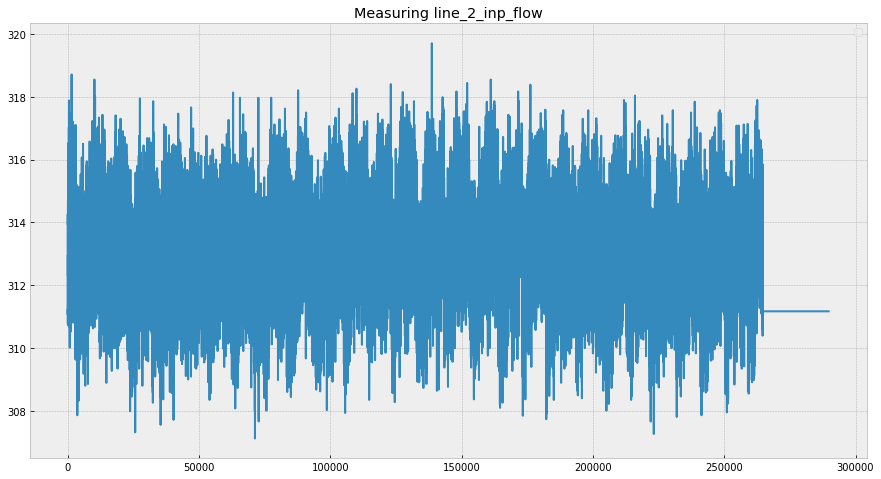

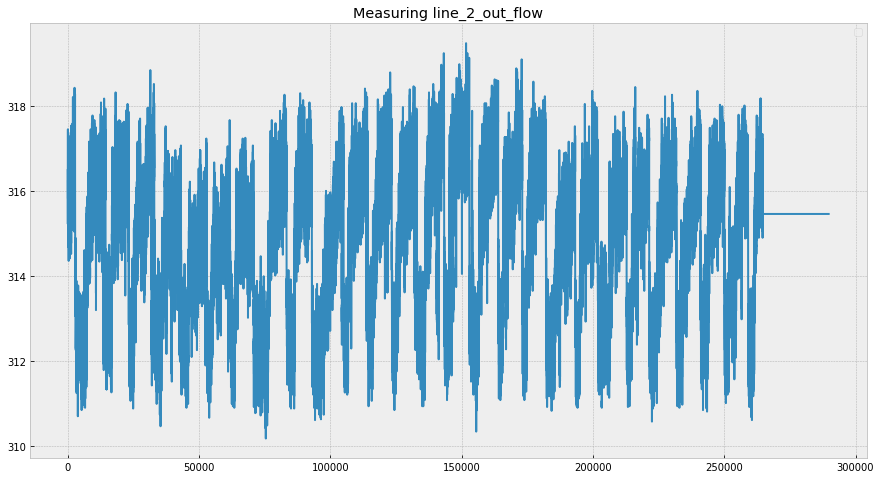

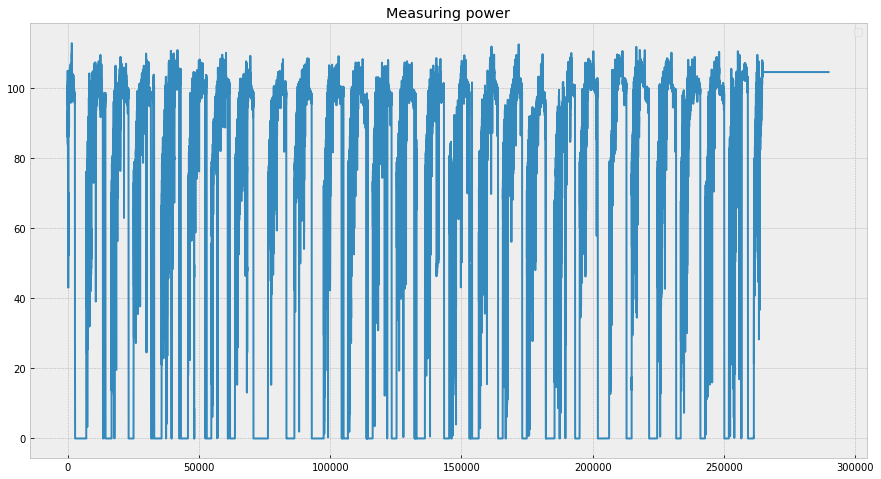

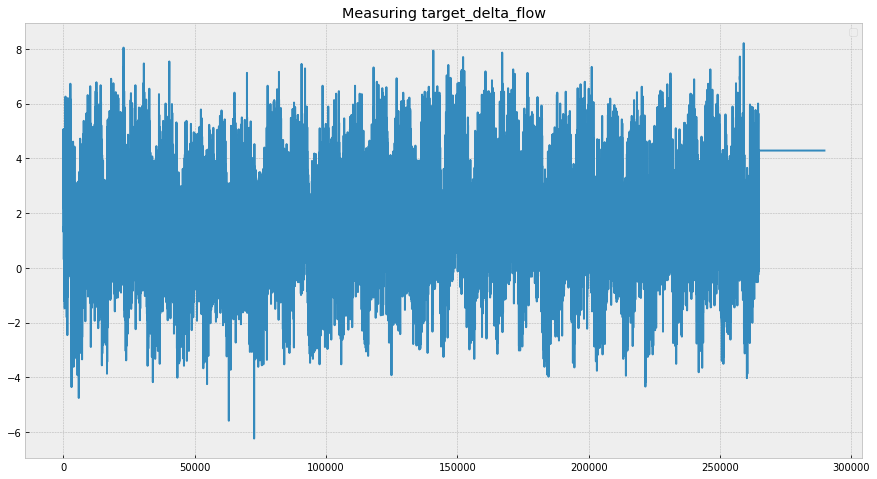

In [39]:
#Plot data
for k in df.columns:
    with plt.style.context('bmh'):    
        plt.figure(figsize=(15, 8))
        plt.title("Measuring %s"%k)
        plt.plot(df[k]);
        plt.legend(loc="best")

No handles with labels found to put in legend.


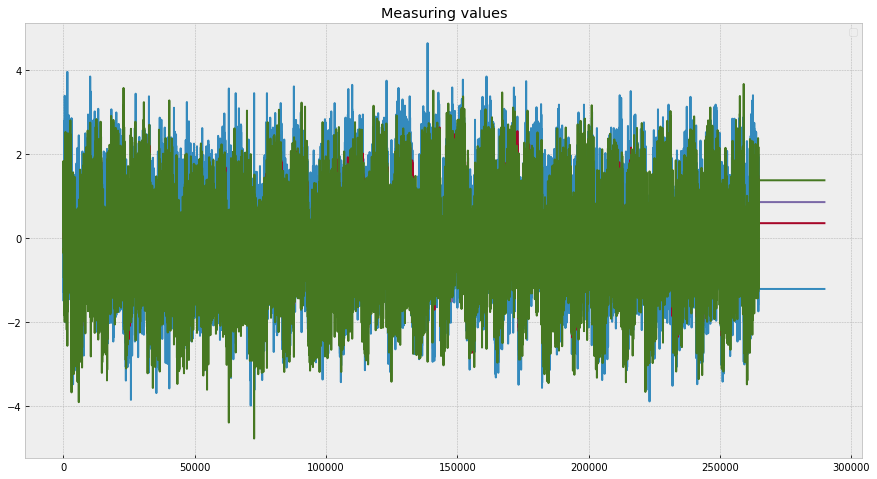

In [40]:
#строим обрезанные данные 
with plt.style.context('bmh'):    
    plt.figure(figsize=(15, 8))
    plt.title('Measuring values')
    df_rescaled = pd.DataFrame(StandardScaler().fit_transform(df))
    #df_rescaled = pd.DataFrame(MinMaxScaler(feature_range=(-1, 1)).fit_transform(df))
    for k in df_rescaled.columns:
        plt.plot(df_rescaled[k]);
    plt.legend(loc="best")

In [41]:
#################################Linear regresion - ElasticNet/ SVR
#linear = LinearRegression()
#lasso = Lasso()
#ridge = Ridge()
elasticnet = ElasticNet()
#srv = SVR(kernel='rbf',verbose=True) #C=1e3, gamma=0.1


pca1 = PCA(0.95, random_state = RANDOM_STATE)
scaler1 = StandardScaler()
scaler2 = MinMaxScaler(feature_range=(-1, 1))
srv_pipe = Pipeline([   
                        #('pca1',pca1),                    
                        #('scaler1',scaler1),
                        #('scaler2',scaler2),
                        #('poly', PolynomialFeatures(degree=2)),
                        #('linear', linear) 
                        #('lasso', lasso)
                        #('ridge', ridge)
                        ('elasticnet', elasticnet) 
                        #('srv', srv) 
                        
                        
                        
                        ])

srv_pipe_params = {#'srv__C': np.logspace(-0, 6, 4) 
                    #,'srv__gamma': np.logspace(-4, 1, 4) 
                   #,'srv__loss' : ['epsilon_insensitive','squared_epsilon_insensitive']
                    #'srv__kernel: ['rbf', 'linear','poly'] 
                    
                    #'lasso__alpha' : np.logspace(-4, 2, 4) 
                    #'linear__fit_intercept ' : [True,False] 
                    #'ridge__alpha' : np.logspace(0, 4, 4)
                    'elasticnet__alpha' : np.logspace(-4, 1, 4) 
                    ,'elasticnet__l1_ratio' : np.logspace(-2, 1, 4) 
                    }
#svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
#svr_lin = SVR(kernel='linear', C=1e3)
#svr_poly = SVR(kernel='poly', C=1e3, degree=2)  

model = GridSearchCV(srv_pipe, cv=5, param_grid=srv_pipe_params, scoring='neg_mean_squared_error',verbose=1,n_jobs=-1)

model.fit(X_train.reshape(-1, 15), y_train[:,])
print("Best: %f using %s" % (model.best_score_, model.best_params_))
means = model.cv_results_['mean_test_score']
stds = model.cv_results_['std_test_score']
params = model.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  4.1min finished


Best: -0.086289 using {'elasticnet__alpha': 0.0001, 'elasticnet__l1_ratio': 10.0}
-0.086685 (0.015231) with: {'elasticnet__alpha': 0.0001, 'elasticnet__l1_ratio': 0.01}
-0.086677 (0.015233) with: {'elasticnet__alpha': 0.0001, 'elasticnet__l1_ratio': 0.1}
-0.086606 (0.015246) with: {'elasticnet__alpha': 0.0001, 'elasticnet__l1_ratio': 1.0}
-0.086289 (0.015216) with: {'elasticnet__alpha': 0.0001, 'elasticnet__l1_ratio': 10.0}
-0.093138 (0.016396) with: {'elasticnet__alpha': 0.004641588833612782, 'elasticnet__l1_ratio': 0.01}
-0.093130 (0.016319) with: {'elasticnet__alpha': 0.004641588833612782, 'elasticnet__l1_ratio': 0.1}
-0.094376 (0.015772) with: {'elasticnet__alpha': 0.004641588833612782, 'elasticnet__l1_ratio': 1.0}
-0.097888 (0.019455) with: {'elasticnet__alpha': 0.004641588833612782, 'elasticnet__l1_ratio': 10.0}
-0.263015 (0.037943) with: {'elasticnet__alpha': 0.21544346900318845, 'elasticnet__l1_ratio': 0.01}
-0.263063 (0.029615) with: {'elasticnet__alpha': 0.21544346900318845, 

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1202.050197875651, tolerance: 85.25081750207455
  positive)


No handles with labels found to put in legend.


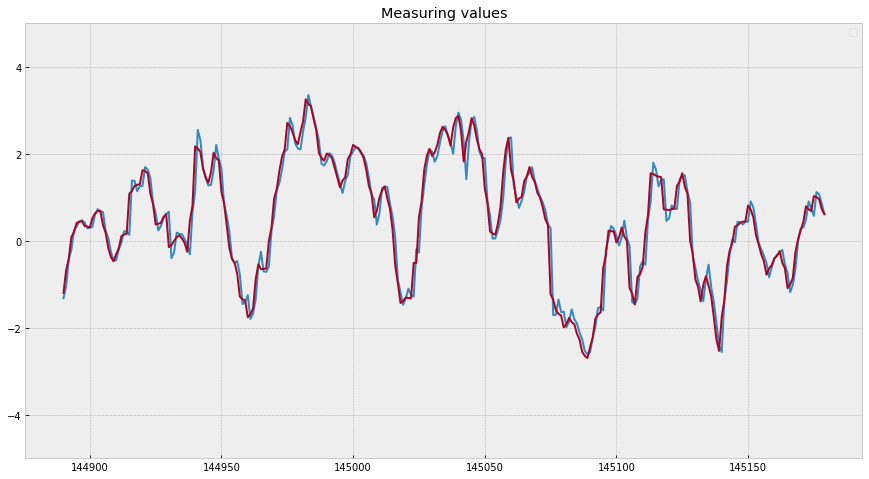

In [48]:
plot_predicted(X_train.reshape(-1, 15),y_train[:,],model,range_low = 0.5,range_high=0.501, range_up = 5, range_down = -5)